In [ ]:
import mosdef_cassandra as mc
import unyt as u
import numpy as np
import os
os.chdir(os.getcwd() + "/mc_bug_test")
print(os.getcwd())

In [4]:
#Inititalize counter to 2 (the failure) and number of eq_steps
count = 1
# Load the initial eq data from the original simulation
init_gemc_liq = "gemc.eq.out.box1.prp"
init_gemc_vap = "gemc.eq.out.box2.prp"
df_box1 = np.genfromtxt(init_gemc_liq)
df_box2 = np.genfromtxt(init_gemc_vap)
n_orig = 10000
eq_extend = 500 #This is the minimum to generate a checkpoint file
#While we are using at most 4 attempts to equilibrate
while count <= 5:
    # Check if equilibration is reached via the pymser algorithms (not shown)
    is_equil = False
    #If equilibration is reached, break the loop and start production
    if is_equil:
        break
    else:
        #Increase the total number of eq steps by 25% of the original value and restart the simulation
        total_eq_steps = n_orig + int(eq_extend*count)
        #If we've exceeded the maximum number of equilibrium steps, raise an exception
        if count == 5:
            raise Exception(f"GEMC equilibration failed to converge after {eq_extend*4} extra steps")
        #Otherwise continue equilibration
        else:
            if count == 1:
                #Restart the simulation from the initial simulation
                #This iteration runs fine
                restart_from_name = "gemc.eq"
            else:
                #Restart the simulation from the last successful equilibration
                #Using this key fails since the #Start_Type section in the input file has no second line
                restart_from_name = f"gemc.eq.rst.{count-1:03d}"
            mc.restart(
            restart_from=restart_from_name,
            run_type="equilibration",
            total_run_length=total_eq_steps,
            run_name = f"gemc.eq.rst.{count:03d}" )
            #Add restart data to eq_col
            # After each restart, load the updated properties data for both boxes
            sim_box1 =  "gemc.eq" + f".rst.{count:03d}" + ".out.box1.prp"
            sim_box2 =  "gemc.eq" + f".rst.{count:03d}" + ".out.box2.prp"
            df_box1r = np.genfromtxt(sim_box1)
            df_box2r = np.genfromtxt(sim_box2)
    #Increase the counter
    count += 1

Using the following executables for Cassandra:
Python: /afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/bin/python
library_setup: /afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/bin/library_setup.py
Cassandra: /afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/bin/cassandra.exe
Running Cassandra...
Using the following executables for Cassandra:
Python: /afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/bin/python
library_setup: /afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/bin/library_setup.py
Cassandra: /afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/bin/cassandra.exe
Running Cassandra...
Using the following executables for Cassandra:
Python: /afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/bin/python
library_setup: /afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/bin/library_setup.py
Cassandra: /afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/bin/cassandra.exe
Running Cassandra...
Using the following executables for Cassandra:
Py

Exception: GEMC equilibration failed to converge after 2000 extra steps

In [6]:
# Process both boxes in one loop
count = 1
eq_data_dict = {}
prop_cols = [5] #Use number of moles to decide equilibrium
for b, box in enumerate([df_box1, df_box2]):
    box_name = "Liquid" if b == 0 else "Vapor"
    for prop_index in prop_cols:
        eq_col = box[:, prop_index - 1]
        #Save eq_col as a csv for later analysis
        key = f"{box_name}_{prop_index}"
        eq_col_file = f"{box_name}_eq_col_{prop_index}.csv"
        np.savetxt(eq_col_file, eq_col, delimiter=",")
        #Save the eq_col and file to a dictionary for later use
        eq_data_dict[key] = {"data": eq_col, "file": eq_col_file}
        
prod_tol_eq = int(eq_data_dict[key]["data"].size/4) 
while count <= 4:
    if count == 1:
        #Restart the simulation from the initial conditions
        restart_from_name = "gemc.eq"
    else:
        #Restart the simulation from the last successful equilibration
        restart_from_name = f"gemc.eq.rst.{count-1:03d}"
        #Add restart data to eq_col
        # After each restart, load the updated properties data for both boxes
        sim_box1 =  "gemc.eq" + f".rst.{count:03d}" + ".out.box1.prp"
        sim_box2 =  "gemc.eq" + f".rst.{count:03d}" + ".out.box2.prp"
        df_box1r = np.genfromtxt(sim_box1)
        df_box2r = np.genfromtxt(sim_box2)

        # Process and add the restart data to eq_col for each property in each box
        for b, box in enumerate([df_box1r, df_box2r]):
            box_name = "Liquid" if b == 0 else "Vapor"
            for i, prop_index in enumerate(prop_cols):
                #Get the key from the property and box name
                key = f"{box_name}_{prop_index}"
                # Extract the column data for this restart and append to accumulated data
                eq_col_restart = box[:, prop_index - 1]
                all_eq_data = np.concatenate((eq_data_dict[key]["data"], eq_col_restart))
                #Save the new data to the eq_col file
                np.savetxt(eq_data_dict[key]["file"], all_eq_data, delimiter=",")
                #Overwite the current data in the eq_data_dict with restart data
                eq_data_dict[key]["data"] = all_eq_data
    count +=1

In [7]:
import matplotlib.pyplot as plt
def plot_res_pymser(eq_col, results, name, box_name):
    fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

    ax1.set_ylabel(name, color="black", fontsize=14, fontweight='bold')
    ax1.set_xlabel("GEMC step", fontsize=14, fontweight='bold')

    ax1.plot(range(len(eq_col)), 
            eq_col, 
            label = 'Raw data', 
            color='blue')

    ax1.plot(range(len(eq_col))[results['t0']:], 
            results['equilibrated'], 
            label = 'Equilibrated data', 
            color='red')

    ax1.plot([0, len(eq_col)], 
            [results['average'], results['average']], 
            color='green', zorder=4, 
            label='Equilibrated average')

    ax1.fill_between(range(len(eq_col)), 
                    results['average'] - results['uncertainty'], 
                    results['average'] + results['uncertainty'], 
                    color='lightgreen', alpha=0.3, zorder=4)

    ax1.set_yticks(np.arange(0, eq_col.max()*1.1, eq_col.max()/10))
    ax1.set_xlim(-len(eq_col)*0.02, len(eq_col)*1.02)
    ax1.tick_params(axis="y", labelcolor="black")

    ax1.grid(alpha=0.3)
    ax1.legend()

    ax2.hist(eq_col, 
            orientation=u'horizontal', 
            bins=30, 
            edgecolor='blue', 
            lw=1.5, 
            facecolor='white', 
            zorder=3)

    ax2.hist(results['equilibrated'], 
            orientation=u'horizontal', 
            bins=3, 
            edgecolor='red', 
            lw=1.5, 
            facecolor='white', 
            zorder=3)

    ymax = int(ax2.get_xlim()[-1])

    ax2.plot([0, ymax], 
            [results['average'], results['average']],
            color='green', zorder=4, label='Equilibrated average')

    ax2.fill_between(range(ymax), 
                    results['average'] - results['uncertainty'],
                    results['average'] + results['uncertainty'],
                    color='lightgreen', alpha=0.3, zorder=4)

    ax2.set_xlim(0, ymax)

    ax2.grid(alpha=0.5, zorder=1)

    fig.set_size_inches(9,5)
    fig.set_dpi(100)
    fig.tight_layout()
    save_name = 'MSER_eq_'+ box_name +'.png'
    # fig.savefig(job.fn(save_name), dpi=300, facecolor='white')
    plt.show()

The results may not be reliable!
The results may not be reliable!


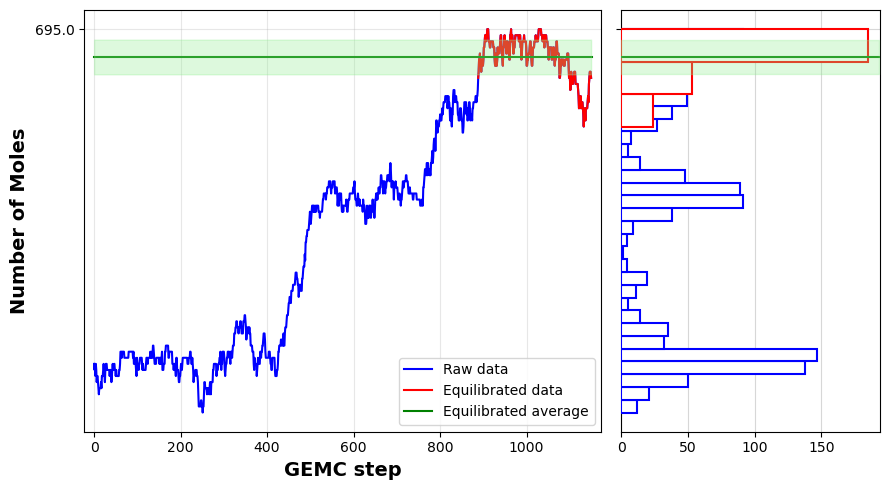

       > Liquid Box Failure! ADF value: -1.631281005118194, 99% confidence value: -3.4561550092339512! 


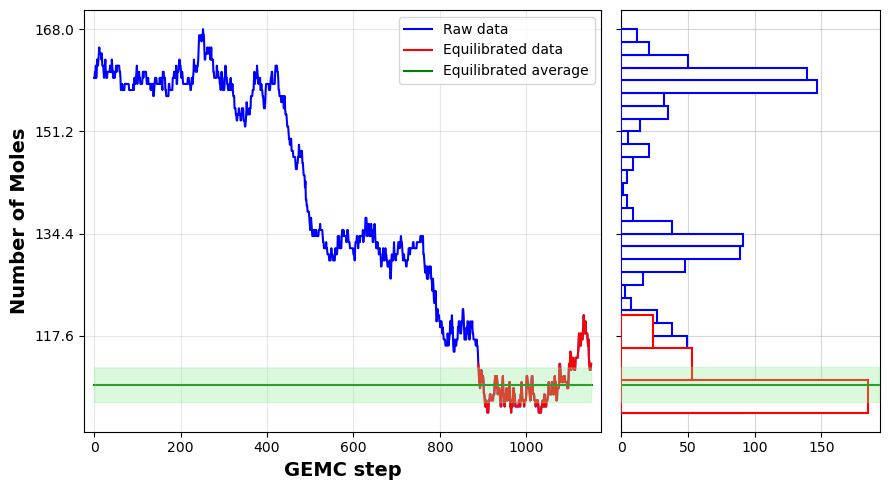

       > Vapor Box Failure! ADF value: -1.6312810051185895, 99% confidence value: -3.4561550092339512! 


In [8]:
import pymser
equil_matrix = []
res_matrix = []
prop_cols = [5]
prop_names = ["Number of Moles"]
# Load data for both boxes
for key in list(eq_data_dict.keys()):
    eq_col = eq_data_dict[key]["data"]
# df_box1 = np.genfromtxt(job.fn("gemc.eq.out.box1.prp"))
# df_box2 = np.genfromtxt(job.fn("gemc.eq.out.box2.prp"))

# Process both boxes in one loop
# for box in [df_box1, df_box2]:
    # for prop_index in prop_cols:
    #     eq_col = box[:, prop_index - 1]
    # print(len(eq_col))
    batch_size = max(1, int(len(eq_col) * 0.0005))

    # Try with ADF test enabled, fallback without it if it fails
    try:
        results = pymser.equilibrate(eq_col, LLM=False, batch_size=batch_size, ADF_test=True, uncertainty='uSD', print_results=False)
        adf_test_failed = results["critical_values"]["1%"] <= results["adf"]
    except:
        results = pymser.equilibrate(eq_col, LLM=False, batch_size=batch_size, ADF_test=False, uncertainty='uSD', print_results=False)
        results["adf"], results["critical_values"], adf_test_failed = None, None, False

    equilibrium = len(eq_col) - results['t0'] >= prod_tol_eq
    equil_matrix.append(equilibrium and not adf_test_failed)
    res_matrix.append(results)

# Log results
# print("ID", job.id, "AT", job.sp.atom_type, "T", job.sp.T)
# print(equil_matrix)
# log_text = '==============================================================================\n'

for i, is_equilibrated in enumerate(equil_matrix):
    # box = df_box1 if i < len(prop_cols) else df_box2
    # box_name = "Liquid" if i < len(prop_cols) else "Vapor"
    # col_vals = box[:, prop_cols[i % len(prop_cols)] - 1]
    key_name = list(eq_data_dict.keys())[i]
    box_name = key_name.rsplit("_", 1)[0]
    col_vals = eq_data_dict[key_name]["data"]
    #plot all

    # if not all(equil_matrix):
    plot_res_pymser(col_vals, res_matrix[i], prop_names[i % len(prop_cols)], box_name)

    # Display outcome
    prod_cycles = len(col_vals) - res_matrix[i]['t0']
    if is_equilibrated:
        #Plot successful equilibration
        statement = f"       > Success! Found {prod_cycles} production cycles."
    else:
        #Plot failed equilibration
        statement = f"       > {box_name} Box Failure! "
        if res_matrix[i]["adf"] is None:
            # Note: ADF test failed to complete
            statement += f"ADF test failed to complete! "
        elif res_matrix[i]['adf'] > res_matrix[i]['critical_values']['1%']:
            adf, one_pct = res_matrix[i]['adf'], res_matrix[i]['critical_values']['1%']
            statement += f"ADF value: {adf}, 99% confidence value: {one_pct}! "
        if len(col_vals) - res_matrix[i]['t0'] < prod_tol_eq:
            statement += f"Only {prod_cycles} production cycles found."
        
    print(statement)